# COBA and CUBA networks

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/COBA.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/COBA.ipynb)

In [1]:
#!pip install ANNarchy

This notebook reproduces the benchmarks used in:

> Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., *J. Comput. Neurosci., 23, 3, 349–98*

They are based on the balanced network proposed by: 

> Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., *J. Neurosci., 25, 46, 10786–95*

Each network is composed of 4000 neurons (3200 excitatory and 800 inhibitory), reciprocally connected with a probability of 0.02 (sparse connection).

The CUBA network uses a current-based integrate-and-fire neuron model:

$$\tau \cdot \frac{dv (t)}{dt} = E_l - v(t) + g_\text{exc} (t) - g_\text{inh} (t)$$

while the COBA model uses conductance-based IF neurons:

$$\tau \cdot \frac{dv (t)}{dt} = E_l - v(t) + g_\text{exc} (t) * (E_\text{exc} - v(t)) + g_\text{inh} (t) * (E_\text{inh} - v(t)) + I(t)$$
    
Apart from the neuron model and synaptic weights, both networks are equal, so we'll focus on the COBA network here.

The discretization step has to be set to 0.1 ms:

In [2]:
import numpy as np
import ANNarchy as ann

ann.setup(dt=0.1) 

ANNarchy 4.8 (4.8.0) on darwin (posix).


## Neuron definition

In [3]:
COBA = ann.Neuron(
    parameters="""
        El = -60.0          : population
        Vr = -60.0          : population
        Erev_exc = 0.0      : population
        Erev_inh = -80.0    : population
        Vt = -50.0          : population
        tau = 20.0          : population
        tau_exc = 5.0       : population
        tau_inh = 10.0      : population
        I = 20.0            : population
    """,
    equations="""
        tau * dv/dt = (El - v) + g_exc * (Erev_exc - v) + g_inh * (Erev_inh - v ) + I

        tau_exc * dg_exc/dt = - g_exc
        tau_inh * dg_inh/dt = - g_inh
    """,
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

In [4]:
CUBA = ann.Neuron(
    parameters="""
        El = -49.0      : population
        Vr = -60.0      : population
        Vt = -50.0      : population
        tau_m = 20.0    : population
        tau_exc = 5.0   : population
        tau_inh = 10.0  : population
    """,
    equations="""
        tau_m * dv/dt = (El - v) + g_exc - g_inh 

        tau_exc * dg_exc/dt = - g_exc 
        tau_inh * dg_inh/dt = - g_inh 
    """,
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

The neurons define exponentially-decreasing conductance g_exc and g_inh for the excitatory and inhibitory conductances/currents, respectively. They also define a refractory period of 5 ms.

## Population

In [5]:
# COBA network
P_COBA = ann.Population(geometry=4000, neuron=COBA)
P_COBA_E = P_COBA[:3200] ; P_COBA_I = P_COBA[3200:]

# CUBA network
P_CUBA = ann.Population(geometry=4000, neuron=CUBA)
P_CUBA_E = P_CUBA[:3200] ; P_CUBA_I = P_CUBA[3200:]

For both networks, we create a population of COBA neurons, and assign the 3200 first ones to an excitatory sub-population and the 800 last ones to an inhibitory sub-population.

It would have been equivalent to declare two separate populations as:

```python
P_COBA_E = ann.Population(geometry=3200, neuron=COBA)
P_COBA_I = ann.Population(geometry= 800, neuron=COBA)
```

but splitting a global population allows to apply methods to all neurons, for example when recording all spikes with a single monitor, or when initializing populations parameters uniformly.

We now initialize the variables of both populations:

In [6]:
# COBA
P_COBA.v = ann.Normal(-55.0, 5.0)
P_COBA.g_exc = ann.Normal(4.0, 1.5)
P_COBA.g_inh = ann.Normal(20.0, 12.0)

# CUBA
P_CUBA.v = ann.Uniform(-60.0, -50.0)

## Connections

The neurons are randomly connected with a probability of 0.02. Excitatory neurons project on all other neurons with the target "exc" and a weight of 0.6 (COBA) or , while the inhibitory neurons have the target "inh" and a weight of 6.7.

In [7]:
# COBA
we_COBA = 0.6
wi_COBA = 6.7
Ce_COBA = ann.Projection(pre=P_COBA_E, post=P_COBA, target='exc')
Ce_COBA.connect_fixed_probability(weights=we_COBA, probability=0.02)

Ci_COBA = ann.Projection(pre=P_COBA_I, post=P_COBA, target='inh')
Ci_COBA.connect_fixed_probability(weights=wi_COBA, probability=0.02)

# CUBA
we_CUBA = 0.27 * 60.0 / 10.0 # 0.7 * (Vmean - E_rev_exc) / gL (mV)
wi_CUBA = 4.5 * 20.0 / 10.0 # 4.5 * (Vmean - E_rev_inh) / gL (mV)
Ce_CUBA = ann.Projection(pre=P_CUBA_E, post=P_CUBA, target='exc')
Ce_CUBA.connect_fixed_probability(weights=we_CUBA, probability=0.02)

Ci_CUBA = ann.Projection(pre=P_CUBA_I, post=P_CUBA, target='inh')
Ci_CUBA.connect_fixed_probability(weights=wi_CUBA, probability=0.02)

In [8]:
ann.compile()

## Simulation

We first define a monitor to record the spikes emitted in the two populations:

In [9]:
m_COBA = ann.Monitor(P_COBA, ['spike'])
m_CUBA = ann.Monitor(P_CUBA, ['spike'])

We can then simulate for 1 second:

In [10]:
ann.simulate(1000.)

We retrieve the recorded spikes from the monitor:

In [11]:
data_COBA = m_COBA.get('spike')
data_CUBA = m_CUBA.get('spike')

and compute a raster plot from the data:

In [12]:
t_COBA, n_COBA = m_COBA.raster_plot(data_COBA)
t_CUBA, n_CUBA = m_CUBA.raster_plot(data_CUBA)

`t` and `n` are lists representing for each spike emitted during the simulation the time at which it was emitted and the index the neuron which fired. The length of this list represents the total number of spikes in the popultion, so we can compute the population mean firing rate:

In [13]:
print('Mean firing rate in the COBA population: ' + str(len(t_COBA) / 4000.) + 'Hz')
print('Mean firing rate in the CUBA population: ' + str(len(t_CUBA) / 4000.) + 'Hz')

Mean firing rate in the COBA population: 20.8135Hz
Mean firing rate in the CUBA population: 5.623Hz


Finally, we can show the raster plot with matplotlib:

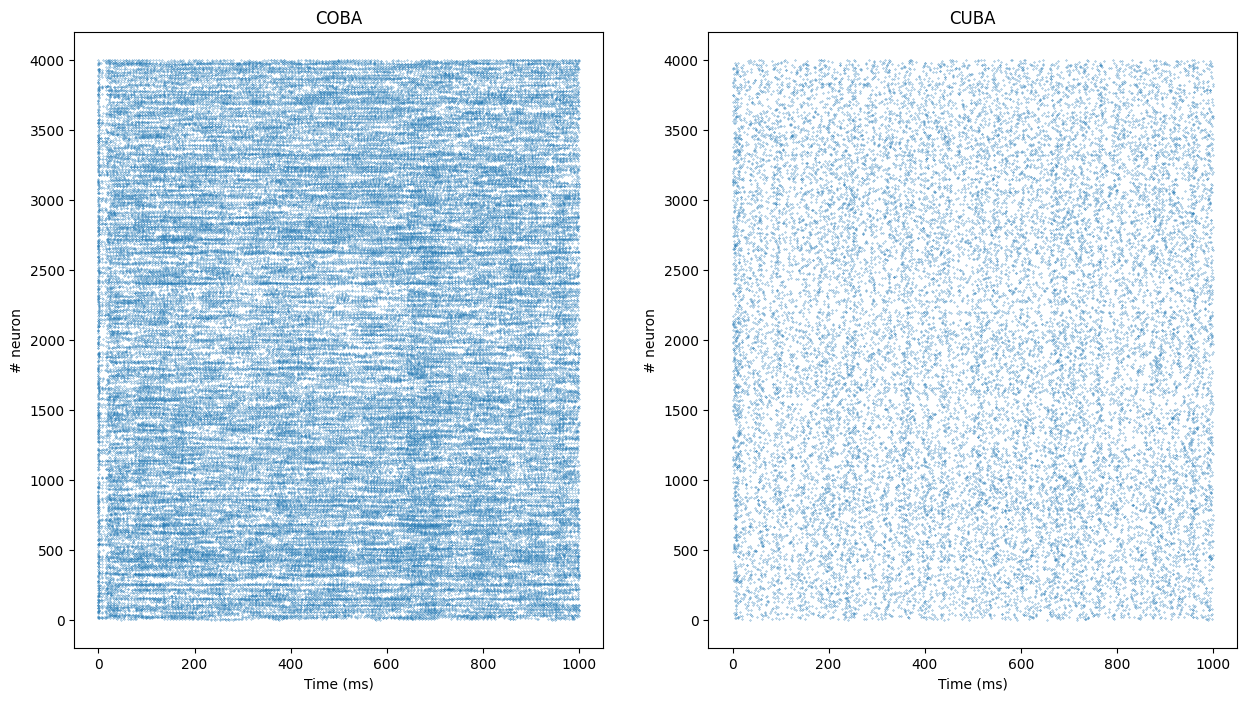

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.title("COBA")
plt.plot(t_COBA, n_COBA, '.', markersize=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')
plt.subplot(122)
plt.title("CUBA")
plt.plot(t_CUBA, n_CUBA, '.', markersize=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')
plt.show()

More detailed information about the activity of the population is provided by the inter-spike interval and the coefficient of variation, for both of which values we offer methods provided by the Monitor class.

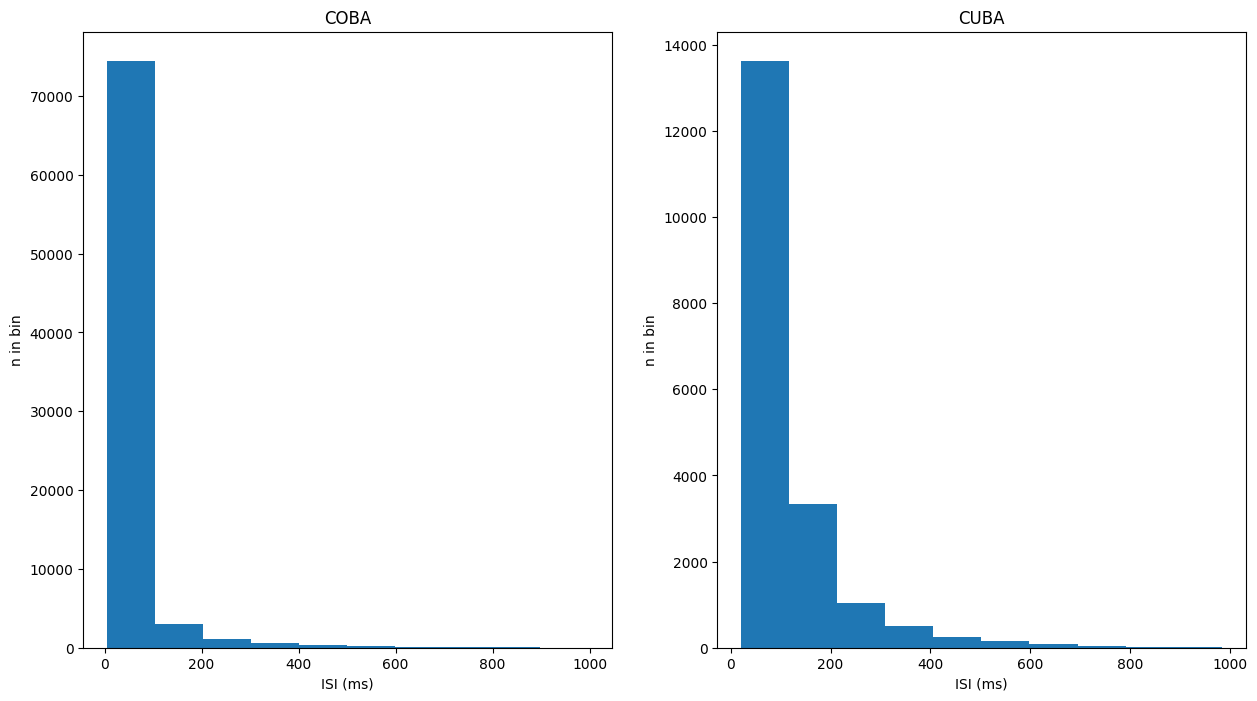

In [16]:
isi_COBA = m_COBA.inter_spike_interval(data_COBA)
isi_CUBA = m_COBA.inter_spike_interval(data_CUBA)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.title("COBA")
plt.hist(isi_COBA)
plt.xlabel('ISI (ms)')
plt.ylabel('n in bin')
plt.subplot(122)
plt.title("CUBA")
plt.hist(isi_CUBA)
plt.xlabel('ISI (ms)')
plt.ylabel('n in bin')
plt.show()

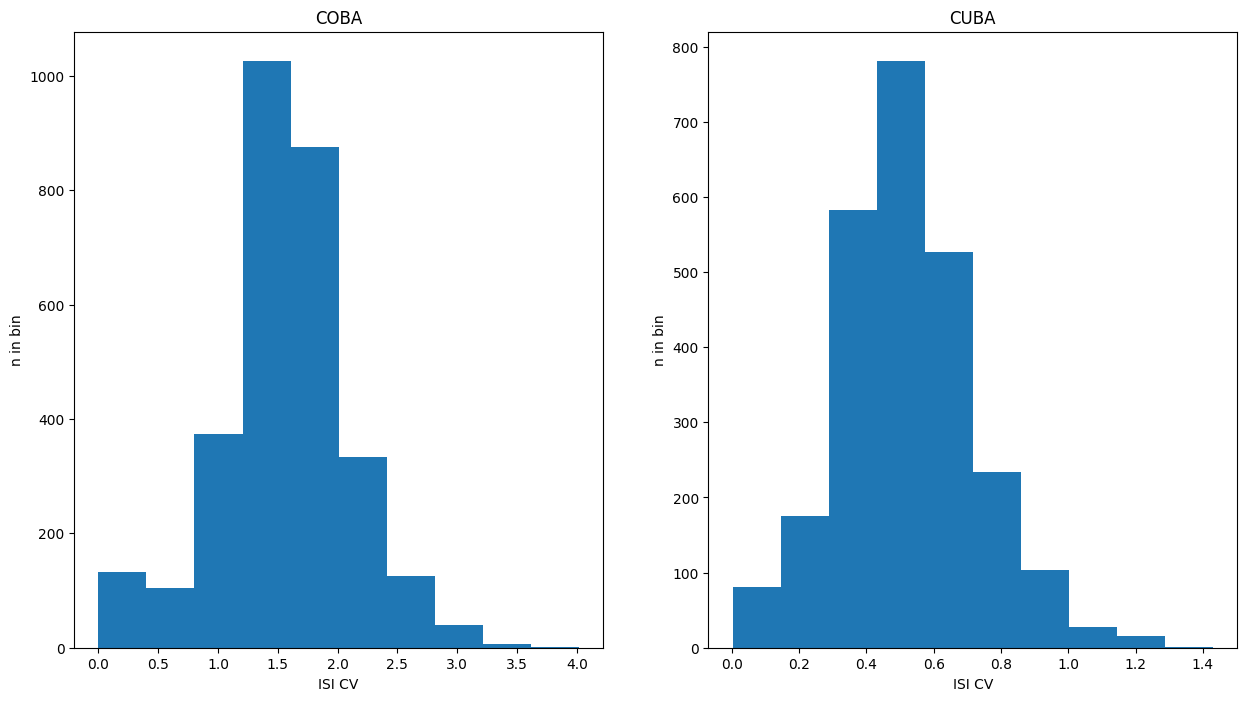

In [17]:
cov_COBA = m_COBA.coefficient_of_variation(data_COBA)
cov_CUBA = m_COBA.coefficient_of_variation(data_CUBA)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.title("COBA")
plt.hist(cov_COBA)
plt.xlabel('ISI CV')
plt.ylabel('n in bin')
plt.subplot(122)
plt.title("CUBA")
plt.hist(cov_CUBA)
plt.xlabel('ISI CV')
plt.ylabel('n in bin')
plt.show()